# Data cleaning

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

# disable pandas warning
pd.options.mode.chained_assignment = None

In [2]:
# read data
df = pd.read_excel('data/Crime_Incidents_in_2012.xlsx', index_col=0)

# drop columns
df = df.drop(['bid'], axis=1)
df.head(3)

,report_dat,shift,method,offense,block,xblock,yblock,ward,anc,district,...,neighborho,block_grou,census_tra,voting_pre,latitude,longitude,start_date,end_date,objectid,octo_recor
ccn,,,,,,,,,,,,,,,,,,,,,
99258578,2012-10-20T00:00:00.000Z,MIDNIGHT,OTHERS,SEX ABUSE,1900 - 1999 BLOCK OF 9TH STREET NW,397921,138712,1,1B,3,...,Cluster 3,004400 2,4400.0,Precinct 137,38.916273,-77.023973,1999-02-17T00:00:00.000Z,1999-02-17T00:00:00.000Z,312507991,99258578-01
12014196,2012-01-29T00:00:00.000Z,MIDNIGHT,OTHERS,HOMICIDE,290 - 399 BLOCK OF TAYLOR STREET NE,399884,141428,5,5A,4,...,Cluster 20,009501 3,9501.0,Precinct 68,38.940742,-77.001338,2012-01-29T03:04:00.000Z,2012-01-29T03:05:11.000Z,312508084,12014196-01
12014196,2012-01-29T00:00:00.000Z,MIDNIGHT,OTHERS,HOMICIDE,290 - 399 BLOCK OF TAYLOR STREET NE,399884,141428,5,5A,4,...,Cluster 20,009501 3,9501.0,Precinct 68,38.940742,-77.001338,2012-01-29T03:04:00.000Z,2012-01-29T03:05:11.000Z,312508085,12014196-02


In [3]:
# check for missing values
df.isna().sum()

report_dat    0
shift         0
method        0
offense       0
block         0
xblock        0
yblock        0
ward          0
anc           0
district      0
psa           0
neighborho    2
block_grou    1
census_tra    1
voting_pre    0
latitude      0
longitude     0
start_date    0
end_date      2
objectid      0
octo_recor    0
dtype: int64

In [4]:
# remove rows with missing value in end_date
df = df[df['end_date'].notna()]

In [5]:
# remove row with start_date in 1999
df = df[df['start_date'].str.contains('1999') == False]

In [6]:
# deal with end_date values that are earlier than start_date values
for row in range(len(df)):
    if df['end_date'].iloc[row][:11] == df['start_date'].iloc[row][:11] and df['end_date'].iloc[row][11:] == '00:00:00.000Z':
        df['end_date'].iloc[row] = df['end_date'].iloc[row][:11] + '23:59:00.000Z'

In [7]:
# export final dataset
df.to_csv('data/Crime_Incidents_in_2012_final.csv')

# Data exploration

In this section, we import other datasets that could help us understand crime data in DC at ward-level.

**Source:** https://www.dchealthmatters.org/

## Proportion of population with annual income below $50,000 - `income`

In [8]:
# example data
pd.read_csv('data/income/Households_by_Income_Ward_Ward_1.csv')

# note that the last column is the percentages for the whole DC (not interested in that)

,Category,Households by Income (Percent),Households by Income (Percent) .1
0,"Under $15,000",9.83,13.16
1,"$15,000 - $24,999",4.46,5.84
2,"$25,000 - $34,999",4.30,5.45
3,"$35,000 - $49,999",6.09,7.44
4,"$50,000 - $74,999",10.57,11.34
5,"$75,000 - $99,999",10.68,10.33
6,"$100,000 - $124,999",10.32,8.99
7,"$125,000 - $149,999",8.94,7.37
8,"$150,000 - $199,999",11.55,9.64
9,"$200,000 - $249,999",6.40,5.33


In [9]:
income = pd.Series([], dtype='float64')
income.name = 'income'  # rename Series
income.index.name = 'ward'  # rename Series index
for ward in range(1, 9):
    temp = pd.read_csv(f'data/income/Households_by_Income_Ward_Ward_{ward}.csv', usecols=[0, 1])  # read first 2 columns of dataset
    temp = round(temp.iloc[:4, 1].sum(), 2)  # extract sum of percentages of income below $50,000
    income[ward] = temp  # store result
income

ward
1    24.68
2    25.39
3    17.74
4    30.13
5    31.82
6    24.29
7    56.48
8    58.65
Name: income, dtype: float64

## Plot data

Let's compute the number of crimes in each ward as `no_crimes`.

In [10]:
# compute the number of crimes in each ward
no_crimes = df.groupby(['ward']).size()
no_crimes.name = 'no_crimes'
no_crimes

ward
1    10
2    13
3     3
4    13
5    15
6    21
7    14
8     8
Name: no_crimes, dtype: int64

In [11]:
# concatenate data
data = pd.concat([income, no_crimes], axis=1)
data

,income,no_crimes
ward,,
1,24.68,10
2,25.39,13
3,17.74,3
4,30.13,13
5,31.82,15
6,24.29,21
7,56.48,14
8,58.65,8


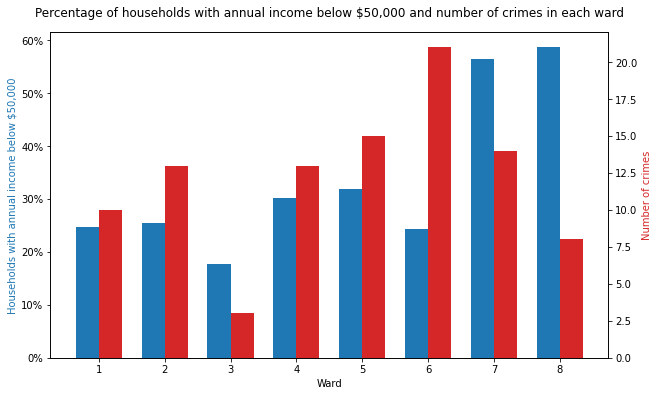

In [12]:
x = data.index  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(10, 6))

# left y-axis
color = 'tab:blue'
ax1.bar(x - width / 2, data['income'], width, color=color)
ax1.set_xlabel('Ward')
ax1.set_ylabel('Households with annual income below $50,000', color=color)
ax1.yaxis.set_major_formatter(tick.PercentFormatter())  # show left y-axis as percentage
#ax1.set_ylim(0, 100)

# right y-axis
color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(x + width / 2, data['no_crimes'], width, color=color)
ax2.set_ylabel('Number of crimes', color=color)

# title
plt.title('Percentage of households with annual income below $50,000 and number of crimes in each ward', pad=15)

plt.savefig('plots/plot.jpeg', dpi=200)

We will compute a simple linear regression model to see if these 2 variables are correlated to one another

## Simple linear regression: `no_crimes ~ income`

In [13]:
# linear regression function
def lr_model(X_var, y_var):
    # convert X_var and y_var to Numpy arrays
    global X, y, results  # access variables outside function
    X, y = np.array(X_var), np.array(y_var)

    # add constant to X
    X = sm.add_constant(X)

    # define model
    model = sm.OLS(y, X)

    # fit model
    results = model.fit()

    # compute summary and return it
    return results.summary()

In [14]:
# compute linear regression model
lr_model(data[['income']], data['no_crimes'])

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.167
Method:                 Least Squares   F-statistic:                 0.0005150
Date:                Tue, 15 Mar 2022   Prob (F-statistic):              0.983
Time:                        22:14:04   Log-Likelihood:                -24.164
No. Observations:                   8   AIC:                             52.33
Df Residuals:                       6   BIC:                             52.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0174      5.157      2.330      0.059      -0.601      24.636
x1             0.0032      0.141      0.023      0.983      -0.342       0.348
==============================================================================
Omnibus:                        0.623   Durbin-Watson:                   1.699
Prob(Omnibus):                  0.732   Jarque-Bera (JB):                0.028
Skew:                          -0.096   Prob(JB):                        0.986
Kurtosis:                       2.783   Cond. No.                         93.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$R^2 = 0$: The model is not useful in explaining the variability in crime numbers. Let's plot the fitted line of the model

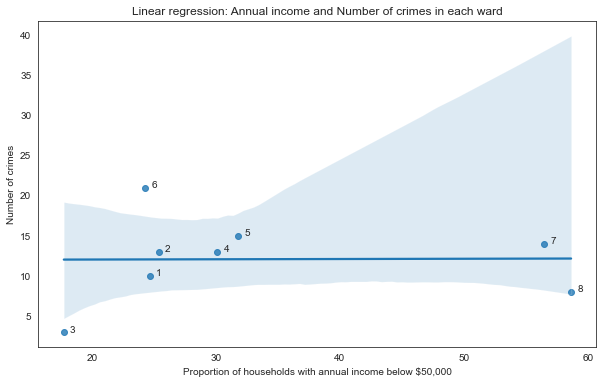

In [15]:
plt.figure(figsize=(10, 6))
sns.set_style('white')

sns.regplot(x=np.delete(X, 0, 1), y=y, color='tab:blue')
[plt.annotate(k, (v['income'] + 0.5, v['no_crimes'])) for k, v in data.iterrows()]  # annotate data points
plt.xlabel('Proportion of households with annual income below $50,000')
plt.ylabel('Number of crimes')
plt.title('Linear regression: Annual income and Number of crimes in each ward')
plt.savefig('plots/simple_lr', dpi=200)

The fitted line is flat. Indeed, the proportion of households with annual income below $50,000 seems irrelevant in explaining the number of crimes in each ward. However, it can be noted that:
1. There is a strong positive relationship between the two variables in wards 1, 2, 3, 4, and 5
2. There is a strong negative relationship between the two variables in wards 5, 7, and 8

Nevertheless, these insights are not very robust as the data sample remains relatively small.

In [16]:
print('No correlation overall:')
data.corr()

No correlation overall:


,income,no_crimes
income,1.000000,0.009264
no_crimes,0.009264,1.000000


In [17]:
print('High positive correlation in ward 1, 2, 3, 4, and 5:')
data[:5].corr()

High positive correlation in ward 1, 2, 3, 4, and 5:


,income,no_crimes
income,1.00000,0.94125
no_crimes,0.94125,1.00000


In [18]:
print('High negative correlation in ward 6, 7, and 8:')
data[5:].corr()

High negative correlation in ward 6, 7, and 8:


,income,no_crimes
income,1.000000,-0.911944
no_crimes,-0.911944,1.000000


## Other variables

In this section we explore extract variables from additional datasets in order to expand our initial linear regression model.

### Proportion of 25+ population without diploma - `education`

In [19]:
# example data
pd.read_csv('data/education/Population_25_by_Educational_Attainment_Ward_Ward_1.csv')

,Category,Population 25+ by Educational Attainment
0,Less than 9th Grade,3406
1,"Some High School, No Diploma",3063
2,High School Grad,6773
3,"Some College, No Degree",5008
4,Associate Degree,1304
5,Bachelor's Degree,21745
6,Master's Degree,18475
7,Professional Degree,7144
8,Doctorate Degree,3106


In [20]:
education = pd.Series([], dtype='float64')
education.name = 'education'  # rename Series
education.index.name = 'ward'  # rename Series index

for ward in range(1, 9):
    temp = pd.read_csv(f'data/education/Population_25_by_Educational_Attainment_Ward_Ward_{ward}.csv')  # read first 2 columns of dataset
    temp = round(temp.iloc[:4, 1].sum() / temp.iloc[:, 1].sum() * 100, 2)  # extract 25+ population without diploma as percentage of total 25+ population
    education[ward] = temp  # store result
education

ward
1    26.06
2    16.68
3    12.08
4    44.51
5    40.91
6    27.46
7    75.23
8    76.06
Name: education, dtype: float64

### Proportion of 16+ population unemployed - `unemployment`

In [21]:
# data
unemployment = pd.read_csv('data/unemployment/chart.csv')
unemployment

,Category,Ward
0,Ward 2,3.69
1,Ward 1,3.90
2,Ward 3,4.14
3,Ward 6,4.76
4,Ward 5,5.82
5,Ward 4,6.01
6,Ward 7,14.76
7,Ward 8,16.02


In [22]:
# rename columns
unemployment = unemployment.rename(columns={'Category': 'ward', 'Ward': 'unemployment'})

# trim 'ward' column
for row in range(len(unemployment)):
    unemployment['ward'][row] = unemployment['ward'][row].replace('Ward ', '')

# convert ward column values to integer
unemployment['ward'] = pd.to_numeric(unemployment['ward'])

# set ward column as index
unemployment = unemployment.set_index('ward')

# convert DataFrame to Series
unemployment = unemployment.squeeze()

unemployment

ward
2     3.69
1     3.90
3     4.14
6     4.76
5     5.82
4     6.01
7    14.76
8    16.02
Name: unemployment, dtype: float64

### Proportion of total population - `population`

In [23]:
# data
population = pd.read_csv('data/population/chart.csv')
population

,Category,Ward
0,Ward 7,77456
1,Ward 8,77756
2,Ward 3,81883
3,Ward 4,83996
4,Ward 5,86794
5,Ward 1,88846
6,Ward 2,89518
7,Ward 6,99652


In [24]:
# rename columns
population = population.rename(columns={'Category': 'ward', 'Ward': 'population'})

# trim 'ward' column
for row in range(len(population)):
    population['ward'][row] = population['ward'][row].replace('Ward ', '')

# convert ward column values to integer
population['ward'] = pd.to_numeric(population['ward'])

# set ward column as index
population = population.set_index('ward')

# convert DataFrame to Series
population = population.squeeze()

# compute ward population as percentage of total DC population
population = round(population / population.sum() * 100, 2)

population

ward
7    11.29
8    11.34
3    11.94
4    12.25
5    12.65
1    12.95
2    13.05
6    14.53
Name: population, dtype: float64

## Multiple linear regression

In this section we compute a multiple linear regression using the data collected.

In [25]:
# concatenate data
data = pd.concat([income, education, unemployment, population, no_crimes], axis=1)
data

,income,education,unemployment,population,no_crimes
ward,,,,,
1,24.68,26.06,3.90,12.95,10
2,25.39,16.68,3.69,13.05,13
3,17.74,12.08,4.14,11.94,3
4,30.13,44.51,6.01,12.25,13
5,31.82,40.91,5.82,12.65,15
6,24.29,27.46,4.76,14.53,21
7,56.48,75.23,14.76,11.29,14
8,58.65,76.06,16.02,11.34,8


In [26]:
# compute linear regression model
lr_model(data.loc[:, data.columns != 'no_crimes'], data['no_crimes'])

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     4.754
Date:                Tue, 15 Mar 2022   Prob (F-statistic):              0.115
Time:                        22:14:04   Log-Likelihood:                -16.191
No. Observations:                   8   AIC:                             42.38
Df Residuals:                       3   BIC:                             42.78
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -60.9006     20.624     -2.953      0.060    -126.536       4.735
x1             0.2794      0.503      0.555      0.617      -1.322       1.881
x2             0.2312      0.191      1.209      0.313      -0.377       0.840
x3            -1.2624      1.267     -0.997      0.392      -5.293       2.768
x4             5.0985      1.525      3.344      0.044       0.246       9.951
==============================================================================
Omnibus:                        0.794   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.672   Jarque-Bera (JB):                0.521
Skew:                          -0.524   Prob(JB):                        0.771
Kurtosis:                       2.316   Cond. No.                     1.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$R^2$ is high, but none of the P-values are significant even at the 10% level. The results are still not conclusive and the model is not useful in explaining the variability in crime numbers.

## Data exploration of the full dataset

In this section we compute a similar linear regression model but instead of using only 100 observations, we will compute it on the whole population data. This new dataset contains more than 35,000 crimes over the year 2012 and will hopefully help us build a more useful model in order to predict the number of crimes in DC.

**Source:** https://opendata.dc.gov/datasets/crime-incidents-in-2012/explore.

In [27]:
# read data
df = pd.read_csv('data/Crime_Incidents_in_2012_full-dataset.csv', index_col=2)

df.head(3)

,X,Y,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,WARD,...,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID
CCN,,,,,,,,,,,,,,,,,,,,,
8254628,-77.050167,38.897172,2012/10/06 04:00:00+00,MIDNIGHT,OTHERS,SEX ABUSE,2200 - 2399 BLOCK OF VIRGINIA AVENUE NW,395648.370000,136591.69000,2,...,010800 3,10800.0,Precinct 2,38.897164,-77.050164,NaN,2008/09/15 04:00:00+00,2008/09/15 04:00:00+00,124344015,NaN
10146732,-77.054008,38.925711,2012/06/08 04:00:00+00,MIDNIGHT,OTHERS,SEX ABUSE,2600 - 2699 BLOCK OF WOODLEY ROAD NW,395317.050000,139759.99000,3,...,000501 3,501.0,Precinct 26,38.925704,-77.054005,NaN,2010/10/09 10:00:00+00,2010/10/09 10:00:00+00,124375849,NaN
11158196,-76.939617,38.910725,2012/01/05 05:00:00+00,MIDNIGHT,OTHERS,HOMICIDE,4280 - 4499 BLOCK OF DOUGLAS STREET NE,405237.243683,138096.74979,7,...,009601 1,9601.0,Precinct 92,38.910717,-76.939615,NaN,2011/10/27 22:35:00+00,2011/10/27 04:00:00+00,124395679,NaN


In [28]:
# recompute the number of crimes per ward
no_crimes = df.groupby(['WARD']).size()
no_crimes.name = 'no_crimes'

# replace the number of crimes in data
data['no_crimes'] = no_crimes
data

,income,education,unemployment,population,no_crimes
ward,,,,,
1,24.68,26.06,3.90,12.95,5096
2,25.39,16.68,3.69,13.05,6775
3,17.74,12.08,4.14,11.94,1787
4,30.13,44.51,6.01,12.25,2999
5,31.82,40.91,5.82,12.65,4952
6,24.29,27.46,4.76,14.53,4420
7,56.48,75.23,14.76,11.29,4859
8,58.65,76.06,16.02,11.34,4457


In [29]:
# compute linear regression model
lr_model(data.loc[:, data.columns != 'no_crimes'], data['no_crimes'])

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     156.6
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           0.000821
Time:                        22:14:04   Log-Likelihood:                -47.858
No. Observations:                   8   AIC:                             105.7
Df Residuals:                       3   BIC:                             106.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9169.5549   1080.117     -8.489      0.003   -1.26e+04   -5732.139
x1           598.2902     26.351     22.705      0.000     514.431     682.149
x2          -130.0176     10.014    -12.984      0.001    -161.886     -98.149
x3         -1099.0803     66.329    -16.570      0.000   -1310.168    -887.992
x4           540.8363     79.849      6.773      0.007     286.722     794.951
==============================================================================
Omnibus:                        1.536   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.464   Jarque-Bera (JB):                0.996
Skew:                           0.722   Prob(JB):                        0.608
Kurtosis:                       2.049   Cond. No.                     1.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The P-values are all significant at the 1% level.

It seems that this model is able to capture most of the variability in the number of income (Adjusted $R^2 = 0.99$). It is interesting to note that a 1% increase in `unemployment` (`x3`) leads to a large reduction of 1,100 in the number of crimes.

However, these findings should be taken with a pinch of salt since there is a high level of autocorrelation amongst the variables `income`, `education`, and `unemployment` (see below).

In [30]:
data.corr()

,income,education,unemployment,population,no_crimes
income,1.000000,0.970592,0.981539,-0.656658,0.196387
education,0.970592,1.000000,0.950274,-0.627710,0.078387
unemployment,0.981539,0.950274,1.000000,-0.697657,0.041481
population,-0.656658,-0.627710,-0.697657,1.000000,0.266919
no_crimes,0.196387,0.078387,0.041481,0.266919,1.000000
